In [ ]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine, text

# Connect to MySQL
conn = mysql.connector.connect(
    host="",
    user="",
    password="",
    
)
cursor = conn.cursor()

# Create database if it doesn't exist
cursor.execute("CREATE DATABASE IF NOT EXISTS customer_products")
cursor.execute("USE customer_products")

# Create tables
cursor.execute("""
CREATE TABLE IF NOT EXISTS customer_purchases (
    id INT AUTO_INCREMENT PRIMARY KEY,
    msisdn VARCHAR(15) NOT NULL,
    product_id INT NOT NULL
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS products (
    product_id INT PRIMARY KEY,
    product_name VARCHAR(100) NOT NULL,
    validity_days INT NOT NULL,
    price DECIMAL(10, 2) NOT NULL
)
""")

# Insert sample data into products
product_data = [
    (1, 'Data Pack 1GB', 7, 49.00),
    (2, 'Data Pack 3GB', 28, 149.00),
    (3, 'Unlimited Calls', 30, 129.00),
    (4, 'Family Pack', 28, 299.00),
    (5, 'International Roaming', 10, 499.00)
]

cursor.executemany(
    "INSERT INTO products (product_id, product_name, validity_days, price) VALUES (%s, %s, %s, %s)",
    product_data
)

# Insert sample customer purchases
customer_data = [
    ('9123456789', 1),
    ('9123456789', 3),
    ('9123456789', 5),
    ('9087654321', 2),
    ('9087654321', 4),
    ('9555555555', 1),
    ('9555555555', 2),
    ('9555555555', 3),
    ('9444444444', 2),
    ('9999999999', 5)
]

cursor.executemany(
    "INSERT INTO customer_purchases (msisdn, product_id) VALUES (%s, %s)",
    customer_data
)

conn.commit()
cursor.close()
conn.close()

print("Database and sample data created successfully!")

Database and sample data created successfully!


In [ ]:
import mysql.connector

# Connect to MySQL
conn = mysql.connector.connect(
    host="",
    user="",
    password="",
    database=""
)

cursor = conn.cursor()

# Additional sample customer purchases
new_customer_data = [
    ('9876543210', 1),
    ('9876543210', 3),
    ('9876543210', 5),
    ('8765432109', 2),
    ('8765432109', 4),
    ('8111111111', 1),
    ('8111111111', 2),
    ('8111111111', 3),
    ('8222222222', 2),
    ('8333333333', 5),
    ('8444444444', 1),
    ('8555555555', 3),
    ('8666666666', 4),
    ('8777777777', 2),
    ('8888888888', 5),
    ('8999999999', 1),
    ('9000000000', 2),
    ('9111111111', 3),
    ('9222222222', 4),
    ('9333333333', 5)
]

cursor.executemany(
    "INSERT INTO customer_purchases (msisdn, product_id) VALUES (%s, %s)",
    new_customer_data
)

conn.commit()
cursor.close()
conn.close()

print("Additional customer data inserted successfully!")


Additional customer data inserted successfully!


In [4]:
# Step 1: Install required packages
import os
import re
from typing import List, Dict, Any, Optional
import pandas as pd
from pprint import pprint

In [5]:

# LangChain imports
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_groq import ChatGroq
from langchain.sql_database import SQLDatabase
from langchain_core.pydantic_v1 import BaseModel, Field

C:\Users\somia.kumari\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# LangGraph imports
from langgraph.graph import StateGraph, END

# Database connection
from sqlalchemy import create_engine, inspect, MetaData, text

# Set Groq API key
os.environ["GROQ_API_KEY"] = ""  # Replace with actual key

# Initialize the LLM
llm = ChatGroq(model="llama3-70b-8192", temperature=0)

# Set up database connection
db_uri = ""
engine = create_engine(db_uri)
db = SQLDatabase.from_uri(db_uri)

In [61]:
def read_msisdns_from_file(file_path: str) -> List[str]:
    """Read MSISDNs from a file, ignoring empty lines and invalid entries."""
    msisdns = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if line and line.isdigit():  # Ensure the line is a valid MSISDN
                    msisdns.append(line)
    except Exception as e:
        print(f"Error reading MSISDNs from file: {e}")
    return msisdns

In [62]:
msisdn_file_path = "C:/Users/somia.kumari/Desktop/msisdn.txt"
msisdns = read_msisdns_from_file(msisdn_file_path)
print(f"MSISDNs read from file: {msisdns}")

MSISDNs read from file: ['9123456789', '9087654321', '9555555555', '9444444444']


In [63]:
# State definition
class AgentState(BaseModel):
    query: str = Field(description="The user's natural language query")
    available_tables: Optional[List[str]] = Field(default=None, description="List of available tables in the database")
    relevant_tables: Optional[List[str]] = Field(default=None, description="List of tables relevant to the query")
    table_schemas: Optional[Dict[str, str]] = Field(default=None, description="DDL definitions of relevant tables")
    generated_sql: Optional[str] = Field(default=None, description="SQL query generated from the user question")
    execution_result: Optional[Any] = Field(default=None, description="Result of executing the SQL query")
    execution_error: Optional[str] = Field(default=None, description="Error message if SQL execution failed")
    corrected_sql: Optional[str] = Field(default=None, description="Corrected SQL query if original query failed")
    final_response: Optional[str] = Field(default=None, description="Final response to the user")
    msisdns: Optional[List[str]] = Field(default=None, description="List of MSISDNs to filter the query")


# Step 1: Fetch available tables
def fetch_available_tables(state: AgentState) -> AgentState:
    """Fetch all available tables from the database"""
    inspector = inspect(engine)
    available_tables = inspector.get_table_names()
    
    return AgentState(
        query=state.query,
        available_tables=available_tables
    )

# Step 2: Determine relevant tables
def determine_relevant_tables(state: AgentState) -> AgentState:
    """Determine which tables are relevant to the user's query"""
    query = state.query
    available_tables = state.available_tables
    
    # Prompt to determine relevant tables
    prompt = PromptTemplate.from_template("""
    You are an expert SQL database analyst. Given the user's question and the list of available tables,
    determine which tables are most likely needed to answer the question.
    
    User question: {query}
    
    Available tables: {available_tables}
    
    Return only a comma-separated list of the relevant table names, nothing else.
    """)
    
    chain = prompt | llm | StrOutputParser()
    tables_string = chain.invoke({
        "query": query,
        "available_tables": ", ".join(available_tables)
    })
    
    # Extract table names (handling potential LLM formatting variations)
    table_pattern = re.compile(r'[\w_]+')
    potential_tables = table_pattern.findall(tables_string)
    
    # Filter to only include actual tables that exist in the database
    relevant_tables = [table for table in potential_tables if table in available_tables]
    
    # If no tables were found but we have available tables, default to all tables
    if not relevant_tables and available_tables:
        relevant_tables = available_tables
    
    return AgentState(
        query=state.query,
        available_tables=state.available_tables,
        relevant_tables=relevant_tables
    )

# Step 3: Retrieve table DDL
def retrieve_table_schemas(state: AgentState) -> AgentState:
    """Retrieve the DDL (schema) information for the relevant tables"""
    relevant_tables = state.relevant_tables
    table_schemas = {}
    
    for table in relevant_tables:
        try:
            # Get column information 
            with engine.connect() as connection:
                inspector = inspect(engine)
                columns = inspector.get_columns(table)
                column_details = []
                
                for column in columns:
                    col_type = str(column['type'])
                    nullable = "NULL" if column.get('nullable', True) else "NOT NULL"
                    default = f"DEFAULT {column.get('default')}" if column.get('default') is not None else ""
                    column_details.append(f"{column['name']} {col_type} {nullable} {default}".strip())
                
                # Get primary key information
                pk_info = inspector.get_pk_constraint(table)
                if pk_info and pk_info.get('constrained_columns'):
                    pk_cols = ", ".join(pk_info['constrained_columns'])
                    column_details.append(f"PRIMARY KEY ({pk_cols})")
                
                # Get foreign key information
                fk_info = inspector.get_foreign_keys(table)
                for fk in fk_info:
                    src_cols = ", ".join(fk['constrained_columns'])
                    ref_table = fk['referred_table']
                    ref_cols = ", ".join(fk['referred_columns'])
                    column_details.append(f"FOREIGN KEY ({src_cols}) REFERENCES {ref_table}({ref_cols})")
                
                # Construct CREATE TABLE statement
                create_stmt = f"CREATE TABLE {table} (\n  " + ",\n  ".join(column_details) + "\n);"
                table_schemas[table] = create_stmt
                
                # Get sample data (first 5 rows)
                sample_data_query = f"SELECT * FROM {table} LIMIT 5"
                sample_df = pd.read_sql(sample_data_query, connection)
                if not sample_df.empty:
                    sample_str = f"\n\n-- Sample data from {table}:\n"
                    sample_str += sample_df.to_string(index=False)
                    table_schemas[table] += sample_str
                    
        except Exception as e:
            table_schemas[table] = f"Error retrieving schema: {str(e)}"
    
    return AgentState(
        query=state.query,
        available_tables=state.available_tables,
        relevant_tables=state.relevant_tables,
        table_schemas=table_schemas
    )

# Step 4: Generate SQL query
def generate_sql_query(state: AgentState) -> AgentState:
    """Generate a SQL query based on the user's question and table schemas."""
    query = state.query
    table_schemas = state.table_schemas
    msisdns = state.msisdns
    
    # Log the MSISDNs for debugging
    print(f"MSISDNs being used: {msisdns}")
    
    # Ensure msisdns is a list of strings
    if msisdns is None:
        msisdns = []
    
    # Convert msisdns to a comma-separated string for the SQL query
    msisdns_str = ", ".join([f"'{msisdn}'" for msisdn in msisdns])
    
    # Prompt for SQL generation
    prompt = PromptTemplate.from_template("""
    You are an expert SQL developer specializing in MySQL syntax. Generate a SQL query to answer this question:
    
    User question: {query}
    
    Here are the relevant database table definitions:
    
    {table_schemas}
    
    Additionally, filter the results to only include rows where the MSISDN is in the following list: {msisdns_str}
    
    Guidelines for query generation:
    1. Use table joins when needed (prefer INNER JOIN over comma joins)
    2. Use appropriate WHERE clauses for filtering
    3. Include ORDER BY for sorting requirements
    4. Add LIMIT clauses when user asks for "top N" results
    5. Use GROUP BY with aggregate functions when appropriate
    6. Ensure all column references are fully qualified (table.column)
    7. Keep the query efficient and focused on answering the specific question
    
    Return only the SQL query, no additional text or explanation.
    """)
    
    schemas_text = "\n\n".join([f"-- Table: {t}\n{schema}" for t, schema in table_schemas.items()])
    
    chain = prompt | llm | StrOutputParser()
    sql_query = chain.invoke({
        "query": query,
        "table_schemas": schemas_text,
        "msisdns_str": msisdns_str
    })
    
    # Clean up the query (remove SQL codeblocks if present)
    sql_query = re.sub(r'```sql\s*|\s*```', '', sql_query).strip()
    
    # Log the generated SQL query for debugging
    print(f"Generated SQL Query: {sql_query}")
    
    return AgentState(
        query=state.query,
        available_tables=state.available_tables,
        relevant_tables=state.relevant_tables,
        table_schemas=state.table_schemas,
        generated_sql=sql_query,
        msisdns=state.msisdns
    )

# Step 5: Validate and optimize SQL
def validate_sql(state: AgentState) -> AgentState:
    """Validate and optimize the generated SQL query while preserving the MSISDN filter."""
    query = state.query
    sql_query = state.generated_sql
    table_schemas = state.table_schemas
    msisdns = state.msisdns

    # Ensure msisdns is a list of strings
    if msisdns is None:
        msisdns = []

    # Convert msisdns to a comma-separated string for the SQL query
    msisdns_str = ", ".join([f"'{msisdn}'" for msisdn in msisdns])

    # Prompt for SQL validation
    prompt = PromptTemplate.from_template("""
    You are an expert SQL reviewer. Review this SQL query for correctness and optimization:
    
    Original User Question: {query}
    Relevant Tables Schemas:
    {table_schemas}
    
    Generated SQL Query: 
    {sql_query}
    
    Additional Requirement:
    - Ensure the query filters results to only include rows where the MSISDN is in the following list: {msisdns_str}
    
    Check for:
    1. Syntax errors or invalid table/column references
    2. Missing JOIN conditions that could cause cartesian products
    3. Inefficient query patterns (missing indexes, unnecessary operations)
    4. Logic errors that would not answer the user's question correctly
    5. Proper use of GROUP BY, HAVING, and aggregation functions
    6. Preservation of the MSISDN filter
    
    If the query looks correct, return it unchanged. If it needs corrections, fix it and return the corrected query.
    Return only the final SQL query with no explanation.
    """)
    
    schemas_text = "\n\n".join([f"-- Table: {t}\n{schema}" for t, schema in table_schemas.items()])
    
    chain = prompt | llm | StrOutputParser()
    validated_sql = chain.invoke({
        "query": query,
        "sql_query": sql_query,
        "table_schemas": schemas_text,
        "msisdns_str": msisdns_str
    })
    
    # Clean up the query (remove SQL codeblocks if present)
    validated_sql = re.sub(r'```sql\s*|\s*```', '', validated_sql).strip()
    
    # Only update if the validated SQL is different
    if validated_sql != sql_query:
        return AgentState(
            query=state.query,
            available_tables=state.available_tables,
            relevant_tables=state.relevant_tables,
            table_schemas=state.table_schemas,
            generated_sql=validated_sql,
            msisdns=state.msisdns
        )
    return state

# Step 6: Execute SQL query
def execute_sql_query(state: AgentState) -> AgentState:
    """Execute the generated SQL query."""
    sql_query = state.generated_sql
    
    # Log the query being executed for debugging
    print(f"Executing SQL Query: {sql_query}")
    
    try:
        # Execute the query
        result = db.run(sql_query)
        
        # Log the execution result for debugging
        print(f"Execution Result: {result}")
        
        # If result is empty, provide a more informative message
        if not result or result.strip() == "":
            result = "Query executed successfully, but returned no results."
            
        return AgentState(
            query=state.query,
            available_tables=state.available_tables,
            relevant_tables=state.relevant_tables,
            table_schemas=state.table_schemas,
            generated_sql=sql_query,
            execution_result=result,
            execution_error=None
        )
        
    except Exception as e:
        error_message = str(e)
        print(f"Execution Error: {error_message}")
        return AgentState(
            query=state.query,
            available_tables=state.available_tables,
            relevant_tables=state.relevant_tables,
            table_schemas=state.table_schemas,
            generated_sql=sql_query,
            execution_result=None,
            execution_error=error_message
        )
# Step 7: Correct SQL on error (if needed)
def correct_sql_on_error(state: AgentState) -> AgentState:
    """Attempt to correct the SQL query if execution failed"""
    if state.execution_error is None:
        return state
    
    query = state.query
    error_message = state.execution_error
    original_sql = state.generated_sql
    table_schemas = state.table_schemas
    
    # Prompt to fix SQL errors
    prompt = PromptTemplate.from_template("""
    You are an expert SQL debugger. The following SQL query failed with an error:
    
    Original user question: {query}
    
    Failed SQL query: 
    {original_sql}
    
    Error message: 
    {error_message}
    
    Database schema information:
    {table_schemas}
    
    Please fix the query to address the error. Common issues include:
    1. Invalid column or table names
    2. Syntax errors in JOIN conditions or WHERE clauses
    3. Type mismatches or invalid operators
    4. Missing GROUP BY columns
    5. Referencing non-existent tables or columns
    
    Return only the corrected SQL query with no explanation.
    """)
    
    schemas_text = "\n\n".join([f"-- Table: {t}\n{schema}" for t, schema in table_schemas.items()])
    
    chain = prompt | llm | StrOutputParser()
    corrected_sql = chain.invoke({
        "query": query,
        "original_sql": original_sql,
        "error_message": error_message,
        "table_schemas": schemas_text
    })
    
    # Clean up the query (remove SQL codeblocks if present)
    corrected_sql = re.sub(r'```sql\s*|\s*```', '', corrected_sql).strip()
    
    # Execute the corrected query
    try:
        result = db.run(corrected_sql)
        if not result or result.strip() == "":
            result = "Query executed successfully after correction, but returned no results."
            
        return AgentState(
            query=state.query,
            available_tables=state.available_tables,
            relevant_tables=state.relevant_tables,
            table_schemas=state.table_schemas,
            generated_sql=state.generated_sql,
            execution_result=result,
            execution_error=None,
            corrected_sql=corrected_sql
        )
        
    except Exception as e:
        # If correction still fails, return both errors
        secondary_error = str(e)
        return AgentState(
            query=state.query,
            available_tables=state.available_tables,
            relevant_tables=state.relevant_tables,
            table_schemas=state.table_schemas,
            generated_sql=state.generated_sql,
            execution_result=None,
            execution_error=f"Original error: {state.execution_error}\n\nCorrection attempt failed with: {secondary_error}",
            corrected_sql=corrected_sql
        )

# Step 8: Formulate response
def formulate_response(state: AgentState) -> AgentState:
    """Formulate a human-readable response based on query results"""
    query = state.query
    sql_query = state.corrected_sql if state.corrected_sql else state.generated_sql
    result = state.execution_result
    error = state.execution_error
    
    if error:
        # Handle the case where even the correction failed
        prompt = PromptTemplate.from_template("""
        The database query to answer the user's question encountered errors that could not be fixed automatically.
        
        User question: {query}
        
        SQL query attempted: {sql_query}
        
        Error message: {error}
        
        Provide a helpful response that:
        1. Acknowledges the technical issue
        2. Explains in simple terms what might be wrong
        3. Suggests how the user might rephrase their question
        """)
        
        chain = prompt | llm | StrOutputParser()
        response = chain.invoke({
            "query": query,
            "sql_query": sql_query,
            "error": error
        })
        
    else:
        # Format successful results
        prompt = PromptTemplate.from_template("""
        You are a helpful database assistant. Format the following SQL results into a clear, concise answer.
        
        User question: {query}
        
        SQL query executed: {sql_query}
        
        Query results: {result}
        
        Provide a natural language response that:
        1. Directly answers the user's question
        2. Presents the data in an easily digestible format
        3. Highlights key insights from the results
        4. Is conversational and helpful
        
        Do not mention the SQL query itself unless it's particularly relevant to understanding the answer.
        """)
        
        chain = prompt | llm | StrOutputParser()
        response = chain.invoke({
            "query": query,
            "sql_query": sql_query,
            "result": result
        })
    
    return AgentState(
        query=state.query,
        available_tables=state.available_tables,
        relevant_tables=state.relevant_tables,
        table_schemas=state.table_schemas,
        generated_sql=state.generated_sql,
        execution_result=state.execution_result,
        execution_error=state.execution_error,
        corrected_sql=state.corrected_sql,
        final_response=response
    )

# Define conditional edges
def should_correct_sql(state):
    """Determine if SQL correction is needed based on execution errors"""
    return "correct_sql" if state.execution_error else "formulate_response"

# Build the LangGraph
def build_sql_agent_graph():
    """Build and return the SQL agent graph"""
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("fetch_tables", fetch_available_tables)
    workflow.add_node("determine_tables", determine_relevant_tables)
    workflow.add_node("retrieve_schemas", retrieve_table_schemas)
    workflow.add_node("generate_sql", generate_sql_query)
    workflow.add_node("validate_sql", validate_sql)
    workflow.add_node("execute_sql", execute_sql_query)
    workflow.add_node("correct_sql", correct_sql_on_error)
    workflow.add_node("formulate_response", formulate_response)
    
    # Add edges
    workflow.add_edge("fetch_tables", "determine_tables")
    workflow.add_edge("determine_tables", "retrieve_schemas")
    workflow.add_edge("retrieve_schemas", "generate_sql")
    workflow.add_edge("generate_sql", "validate_sql")
    workflow.add_edge("validate_sql", "execute_sql")
    
    # Add conditional edge
    workflow.add_conditional_edges(
        "execute_sql",
        should_correct_sql,
        {
            "correct_sql": "correct_sql",
            "formulate_response": "formulate_response"
        }
    )
    
    workflow.add_edge("correct_sql", "formulate_response")
    workflow.add_edge("formulate_response", END)
    
    # Set entry point
    workflow.set_entry_point("fetch_tables")
    
    # Compile the graph
    return workflow.compile()

# Create the agent
sql_agent = build_sql_agent_graph()

In [64]:

def query_sql_agent(question: str, msisdn_file_path: str) -> str:
    """Query the SQL agent with a natural language question and filter by MSISDNs."""
    msisdns = read_msisdns_from_file(msisdn_file_path)
    
    # Initialize the state with the query and MSISDNs
    initial_state = AgentState(query=question, msisdns=msisdns)
    
    result = sql_agent.invoke(initial_state)
    
    # Print the result to debug the structure
    print(result)
    
    # Access final_response correctly
    return result.get("final_response", "No response found")

In [72]:
if __name__ == "__main__":
    sample_questions = [
        "give me top 3 products"
    ]
    
    # msisdn_file_path = "C:/Users/somia.kumari/Desktop/msisdn.txt"
    
    for question in sample_questions:
        print(f"\nQuestion: {question}")
        print("-" * 50)
        answer = query_sql_agent(question, msisdn_file_path)
        print(f"Answer: {answer}")
        print("=" * 80)


Question: give me top 3 products
--------------------------------------------------
MSISDNs being used: ['9123456789', '9087654321', '9555555555', '9444444444']
Generated SQL Query: SELECT p.*
FROM products p
INNER JOIN (
  SELECT product_id
  FROM user_products
  WHERE msisdn IN ('9123456789', '9087654321', '9555555555', '9444444444')
  GROUP BY product_id
) up ON p.product_id = up.product_id
ORDER BY p.price DESC
LIMIT 3;
Executing SQL Query: Here is the reviewed and optimized SQL query:
SELECT p.*
FROM products p
WHERE p.product_id IN (
  SELECT up.product_id
  FROM user_products up
  WHERE up.msisdn IN ('9123456789', '9087654321', '9555555555', '9444444444')
)
ORDER BY p.price DESC
LIMIT 3;
Execution Error: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'Here is the reviewed and optimized SQL query:\nSELECT p.*\nFROM products p\nWHERE p' at line 1")
[SQL: H

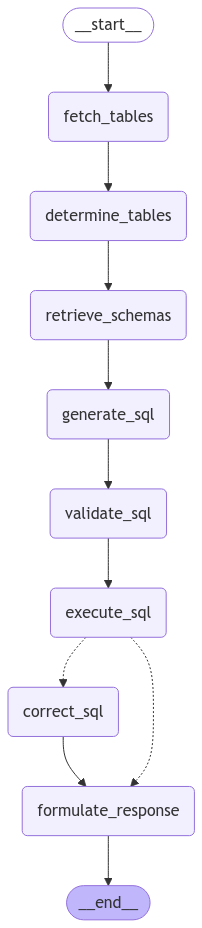

In [71]:
from IPython.display import Image, display  # Fixed import for Image
from langchain_core.runnables.graph import MermaidDrawMethod
# Display the workflow graph
display(
    Image(
        sql_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)